In [1]:
import os
if "models" not in os.listdir("."):
    os.chdir("..")

In [3]:
%load_ext autoreload
%autoreload 2
import penzai
from penzai import pz
pz.ts.register_as_default()
pz.ts.register_autovisualize_magic()
pz.enable_interactive_context()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import jax.numpy as jnp
import jax
import json

from tqdm.auto import tqdm

In [5]:
from micrlhf.llama import LlamaTransformer
from transformers import AutoTokenizer


filename = "models/phi-3-16.gguf"
llama = LlamaTransformer.from_pretrained(filename, device_map="auto")
tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3-mini-4k-instruct")
tokenizer.padding_side = "right"

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [6]:
from micrlhf.utils.activation_manipulation import replace_activation, collect_activations

def benchmark_vector(vector, tokens, model, positions, replacement_layer, layer=24):
    act_rep = collect_activations(replace_activation(model, vector, positions, layer=replacement_layer))
    logits, residuals = act_rep(tokens)
    return logits, residuals[layer].value

In [7]:
def tokens_to_inputs(tokens):
    token_array = jnp.asarray(tokens)
    token_array = jax.device_put(token_array, jax.sharding.NamedSharding(llama.mesh, jax.sharding.PartitionSpec("dp", "sp")))
    token_array = pz.nx.wrap(token_array, "batch", "seq").untag("batch").tag("batch")

    inputs = llama.inputs.from_basic_segments(token_array)
    return inputs

In [8]:
def logits_to_loss(logits, tokens, answer_start, pad_token=32000):
    logits = jax.nn.log_softmax(logits)

    logits = logits[:, :-1]
    logits = jnp.take_along_axis(logits, tokens[:, 1:, None], axis=-1).squeeze(-1)

    mask = tokens[:, 1:] != pad_token

    mask[:, :answer_start-1] = False

    logits = logits * mask

    return -logits.sum(axis=-1) / mask.sum(axis=-1)


In [52]:
from micrlhf.utils.load_sae import get_sae

MIN_SCALE = 0
MAX_SCALE = 200
def benchmark_feature(prompt_template, token_to_replace, layer, feature, explanation, batch_size=64,
                      min_scale=MIN_SCALE, max_scale=MAX_SCALE, max_length=64, replacement_layer=2,
                      cfg_scale=1.5):
    direction = get_sae(layer, 4)["W_dec"][feature]
    vector = direction[None, :] * jnp.linspace(min_scale, max_scale, batch_size)[:, None]

    prompt = prompt_template.format(explanation)
    text = [prompt for _ in range(batch_size)]

    tokenized = tokenizer(text, return_tensors="np", padding="max_length", max_length=max_length, truncation=True)

    tokens = tokenized["input_ids"]

    inputs = tokens_to_inputs(tokens)

    positions = [i for i, a in enumerate(tokenizer.encode(prompt_template)) if tokenizer.decode([a]) == token_to_replace]

    logits, residuals = benchmark_vector(
        vector, inputs, llama, positions, replacement_layer
    )

    logits = logits.unwrap(
        "batch", "seq", "vocabulary"
    )
    logits_cfg = logits + (logits - logits[0]) * (cfg_scale - 1)

    answer_start = len(tokenizer.encode(prompt_template.partition("{}")[0]))

    loss = logits_to_loss(logits, tokens, answer_start)
    loss_cfg = logits_to_loss(logits_cfg, tokens, answer_start)
    logprobs = jax.nn.log_softmax(logits)
    entropies = -jnp.sum(logprobs * jnp.exp(logprobs), axis=-1)
    entropy_first = entropies[:, answer_start - 1]
    max_logprob_first = jnp.max(logprobs[:, answer_start - 1], axis=-1)
    resid = residuals.unwrap("batch", "seq", "embedding")[:, answer_start - 1]
    resid_v_feature = resid @ direction
    resid_cos_feature = resid_v_feature / jnp.linalg.norm(resid) / jnp.linalg.norm(direction)

    best_idx = jnp.argmin(loss)

    return (loss, entropy_first, max_logprob_first, resid_v_feature, resid_cos_feature, loss_cfg,
            jnp.linspace(min_scale, max_scale, batch_size)[best_idx], loss[best_idx])

In [53]:
prompt_template = "<|user|>\nWhat is the meaning of the word \"X\"?<|end|>\n<|assistant|>\nThe meaning of the word \"X\" is \"{}\""
token_to_replace = "X"

positions = [i for i, a in enumerate(tokenizer.encode(prompt_template)) if tokenizer.decode([a]) == token_to_replace]

In [54]:
from datasets import load_dataset

feature_dataset = load_dataset("kisate-team/feature-explanations", split="train")

In [55]:
# from tqdm.auto import tqdm
# import numpy as np
# def collect_resids_category(category, max_length=64, replacement_layer=2, n_pick=50):
#     resids_bad = []
#     resids_good = []
#     for item in tqdm(feature_dataset):
#         if len(resids_good) >= n_pick and len(resids_bad) >= n_pick:
#             break
#         if item["rating"] is None:
#             continue
#         # if not item["scale"]:
#         #     continue
#         layer = item["layer"]
#         feature = item["feature"]
#         explanation = item["explanation"]
#         if explanation is None:
#             continue
#         # if min(item["loss"]) > 4:
#         #     continue
#         if item["type"] != category:
#             continue
#         best_scale = item["scale"] or 0.0
    
#         vector = get_sae(layer, 4)["W_dec"][feature]
#         vector = vector[None, :] * jnp.full((4, 1), best_scale)

#         prompt = prompt_template.format(explanation)
#         text = [prompt] * 4

#         tokenized = tokenizer(text, return_tensors="np", padding="max_length", max_length=max_length, truncation=True)

#         tokens = tokenized["input_ids"]

#         inputs = tokens_to_inputs(tokens)

#         positions = [i for i, a in enumerate(tokenizer.encode(prompt_template)) if tokenizer.decode([a]) == token_to_replace]

#         logits, residuals = benchmark_vector(
#             vector, inputs, llama, positions, replacement_layer
#         )
#         answer_start = len(tokenizer.encode(prompt_template.partition("{}")[0]))
#         residual = residuals.unwrap("batch", "seq", "embedding")[0, answer_start - 1]
#         residual = np.array(residual)
#         if item["rating"] > 0.5:
#             resids_good.append(residual)
#         else:
#             resids_bad.append(residual)
#     return np.array(resids_bad), np.array(resids_good)

# a_resids, b_resids = collect_resids_category("person_profession")

In [56]:
# from matplotlib import pyplot as plt
# from sklearn.decomposition import PCA


# plt.style.use('seaborn-v0_8-darkgrid')
# ab = np.concatenate([a_resids, b_resids], axis=0)
# abxy = PCA(n_components=2).fit_transform(ab)
# plt.scatter(*abxy[:len(a_resids)].T, label="bad")
# plt.scatter(*abxy[len(a_resids):].T, label="good")
# plt.legend()
# plt.show()

In [57]:
# ts = 8
# a, b, c, d = a_resids[:ts], a_resids[ts:], b_resids[:ts], b_resids[ts:]
# e = c.mean(0) - a.mean(0)
# plt.hist(b @ e, alpha=0.5, bins=20, label="bad")
# plt.hist(d @ e, alpha=0.5, bins=20, label="good")
# plt.legend()
# plt.show()

In [58]:
# from sklearn.linear_model import LogisticRegression
# lr = LogisticRegression()
# lr.fit(ab, [0] * len(a_resids) + [1] * len(b_resids))
# direction = lr.coef_[0]

In [59]:
# from sklearn.svm import LinearSVC
# lr = LinearSVC(C=100)
# lr.fit(ab, [0] * len(a_resids) + [1] * len(b_resids))
# direction = lr.coef_[0]

In [60]:
# direction = b_resids.mean(0) - a_resids.mean(0)
# direction = direction / np.linalg.norm(direction)

In [61]:
# c_resids, d_resids = collect_resids_category("location_language")

In [62]:
# direction_ = d_resids.mean(0) - c_resids.mean(0)
# direction_ = direction_ / np.linalg.norm(direction_)
# direction_ = direction
# plt.hist(c_resids @ direction_, label="bad", alpha=0.5)
# plt.hist(d_resids @ direction_, label="good", alpha=0.5)
# plt.legend()
# plt.show()

In [63]:
# all_resids = np.concatenate([c_resids, d_resids], axis=0).mean(0)
# plt.hist(np.linalg.norm(c_resids - all_resids, axis=-1), label="bad", alpha=0.5)
# plt.hist(np.linalg.norm(d_resids - all_resids, axis=-1), label="good", alpha=0.5)
# plt.legend()
# plt.show()

  0%|          | 0/1791 [00:00<?, ?it/s]

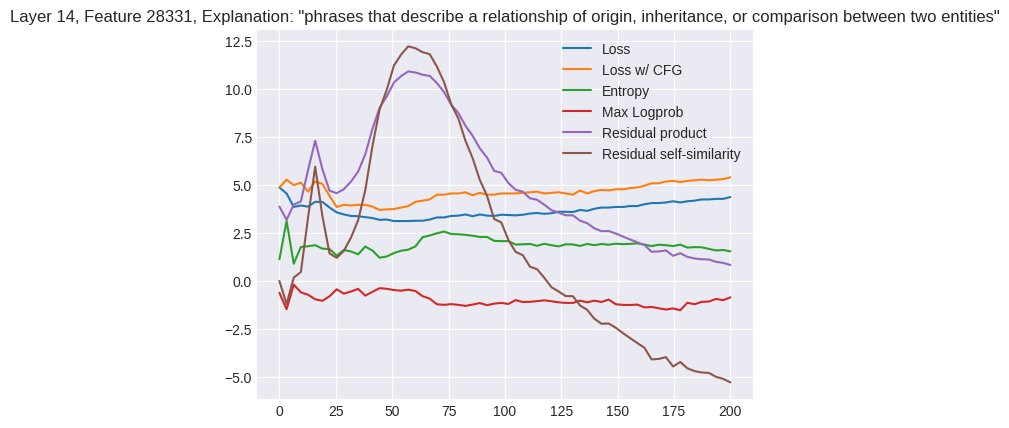

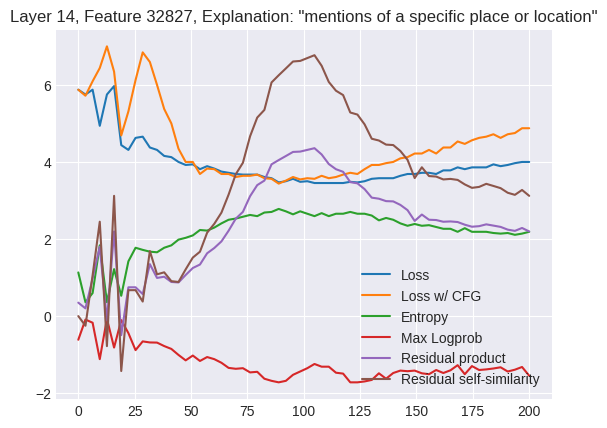

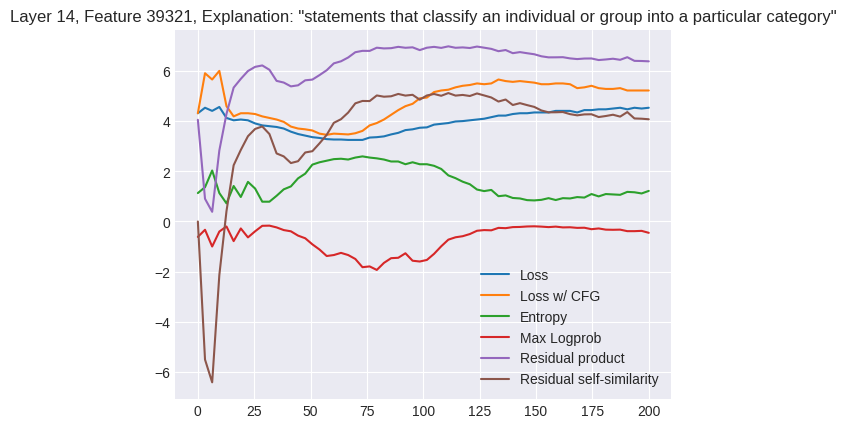

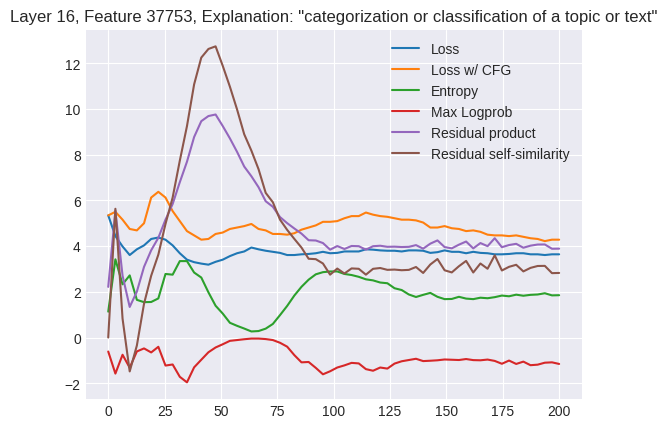

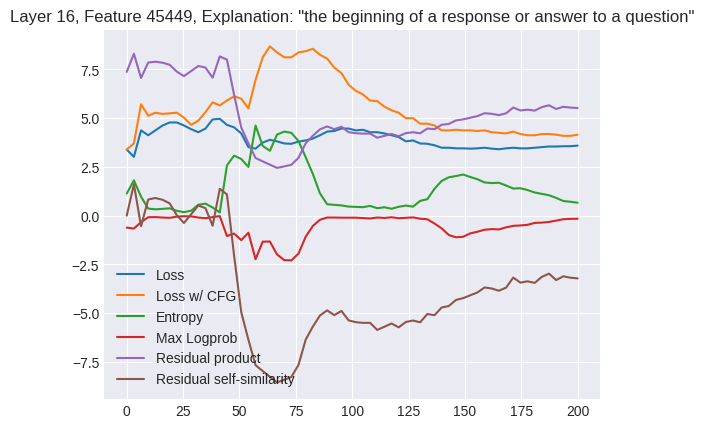

KeyboardInterrupt: 

In [64]:
from matplotlib import pyplot as plt
from tqdm.auto import trange
import numpy as np


plt.style.use('seaborn-v0_8-darkgrid')

replacement_layer = 2

for i in trange(len(feature_dataset)):
    item = feature_dataset[i]
    
    if not item["rating"]:
        continue
    if item["rating"] < 1:
        continue
    if not item["scale"]:
        continue
    layer = item["layer"]
    feature = item["feature"]
    explanation = item["explanation"]
    if explanation is None:
        continue
    if min(item["loss"]) > 4:
        continue

    result = {"id": i}

    (loss, entropy_first, max_logprob_first, resid_v_feature, resid_cos_feature, loss_cfg,
     scale, best_loss) = benchmark_feature(prompt_template, token_to_replace, layer, feature, explanation, replacement_layer=replacement_layer)
    loss = loss.tolist()
    scales = np.linspace(MIN_SCALE, MAX_SCALE, len(loss)).tolist()
    plt.plot(scales, loss, label="Loss")
    plt.plot(scales, loss_cfg, label="Loss w/ CFG")
    plt.plot(scales, entropy_first.tolist(), label="Entropy")
    plt.plot(scales, max_logprob_first.tolist(), label="Max Logprob")
    plt.plot(scales, resid_v_feature.tolist(), label="Residual product")
    plt.plot(scales, ((resid_cos_feature - resid_cos_feature[0]) * 2000).tolist(), label="Residual self-similarity")
    plt.legend()
    plt.title(f"Layer {layer}, Feature {feature}, Explanation: \"{explanation}\"")
    plt.show()

In [ ]:
item = feature_dataset[1]

print(item)

layer = item["layer"]
feature = item["feature"]
explanation = item["explanation"]

In [ ]:
vector = get_sae(layer, 4)["W_dec"][feature]
prompt = "<|user|>\nWhat is the meaning of the word \"X\"?<|end|>\n<|assistant|>\nThe meaning of the word \"X\" is \""
bs = 64
msl = 64

act_rep = replace_activation(llama, vector[None, :] * jnp.linspace(8, 10, bs)[:, None], prompt=prompt, tokenizer=tokenizer, layer=2)

In [ ]:
from micrlhf.sampling import sample
texts = sample(act_rep, tokenizer, prompt, batch_size=bs, do_sample=True, max_seq_len=msl)[0]

In [ ]:
display(texts)

In [ ]:
with open("results.jsonl", "r") as f:
    results = [json.loads(l) for l in f]

In [ ]:
results = [r for r in results if "loss" in r]
results = [r for r in results if r["scale"] > 0.0]

In [ ]:
sample = results[128:128+128]
idx = [x["id"] for x in sample]

dataset_sample = feature_dataset.select(idx)

In [ ]:
scales = [r["scale"] for r in sample]
scales = jnp.array(scales)

vectors = []

for r in dataset_sample:
    layer = r["layer"]
    feature = r["feature"]
    vector = get_sae(layer, 4)["W_dec"][feature]
    vectors.append(vector)

vectors = jnp.array(vectors)

In [ ]:
prompt = "<|user|>\nWhat is the meaning of the word \"X\"?<|end|>\n<|assistant|>\nThe meaning of the word \"X\" is \""
# prompt = "<|user|>cat -> cat, apple -> apple, book -> book, build a house -> build a house, \"X\" ->"
bs = 128
msl = 64

In [ ]:
act_rep = replace_activation(llama, vectors * scales[:, None], prompt=prompt, tokenizer=tokenizer, layer=2)

In [ ]:
from micrlhf.sampling import sample
texts = sample(act_rep, tokenizer, prompt, batch_size=bs, do_sample=True, max_seq_len=msl)[0]

In [ ]:
[(x[len(prompt):len(prompt)+100], s["explanation"]) for x, s in zip(texts, dataset_sample)]

In [ ]:
n_repeats = 4
batch_size = 64
prompt = "<|user|>\nWhat is the meaning of the word \"X\"?<|end|>\n<|assistant|>\nThe meaning of the word \"X\" is \""
msl = 64

In [ ]:
from itertools import batched
from micrlhf.sampling import sample

generated_explanations = []

for batch in tqdm(list(batched(results, batch_size))):
    idx = [x["id"] for x in batch]
    dataset_sample = feature_dataset.select(idx)

    scales = [[r["scale"] for _ in range(n_repeats)] for r in batch]
    scales = [x for y in scales for x in y]
    scales = jnp.array(scales)

    vectors = []

    for r in dataset_sample:
        layer = r["layer"]
        feature = r["feature"]
        vector = get_sae(layer, 4)["W_dec"][feature]
        vectors.extend([vector for _ in range(n_repeats)])


    vectors = jnp.array(vectors)

    prompt = "<|user|>\nWhat is the meaning of the word \"X\"?<|end|>\n<|assistant|>\nThe meaning of the word \"X\" is \""

    act_rep = replace_activation(llama, vectors * scales[:, None], prompt=prompt, tokenizer=tokenizer, layer=2)

    texts = sample(act_rep, tokenizer, prompt, batch_size=batch_size*n_repeats, do_sample=True, max_seq_len=msl)[0]

    new_explanations = [
        {"id": r["id"], "explanation": [y[len(prompt):] for y in x]} for r, x in zip(batch, batched(texts, n_repeats)) 
    ]

    generated_explanations.extend(new_explanations)

    with open("gen_explanations.jsonl", "a") as f:
        for x in new_explanations:
            f.write(json.dumps(x) + "\n")
        # f.write(json.dumps(result) + "\n")

    # break

In [ ]:
new_explanations